Imports and read and sample data to correct indervals

In [10]:
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter

from wOpenTimes import ( 
    WINDOW_OPEN_TIMES
)


inside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_temperature.csv', parse_dates=['Time'])
inside_temp_data = inside_temp_data.iloc[1:].reset_index(drop=True)
inside_temp_data.columns = ['Time', 'Temperature']
inside_temp_data['Temperature'] = inside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
inside_temp_data['Temperature'] = pd.to_numeric(inside_temp_data['Temperature'], errors='coerce')

outside_temp_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_temperature.csv', parse_dates=['Time'])
outside_temp_data = outside_temp_data.iloc[1:].reset_index(drop=True)
outside_temp_data.columns = ['Time', 'Temperature']
outside_temp_data['Temperature'] = outside_temp_data['Temperature'].str.replace(' °C', '', regex=False).str.strip()
outside_temp_data['Temperature'] = pd.to_numeric(outside_temp_data['Temperature'], errors='coerce')

inside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/inside_humidity.csv', parse_dates=['Time'])
inside_humidity_data = inside_humidity_data.iloc[1:].reset_index(drop=True)
inside_humidity_data['Humidity'] = inside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
inside_humidity_data['Humidity'] = pd.to_numeric(inside_humidity_data['Humidity'], errors='coerce')

outside_humidity_data = pd.read_csv('/Users/agres/Projects/seb/seb_datascience/src/data_processing/data/outside_humidity.csv', parse_dates=['Time'])
outside_humidity_data = outside_humidity_data.iloc[1:].reset_index(drop=True)
outside_humidity_data['Humidity'] = outside_humidity_data['Humidity'].str.replace(' %', '', regex=False).str.strip()
outside_humidity_data['Humidity'] = pd.to_numeric(outside_humidity_data['Humidity'], errors='coerce')

outside_temp_data = outside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
inside_temp_data = inside_temp_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
inside_humidity_data = inside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()
outside_humidity_data = outside_humidity_data.set_index('Time').resample('1T').interpolate('linear').reset_index()

data_list = [inside_temp_data, outside_temp_data, outside_humidity_data, inside_humidity_data]

Normalize  and merge data into one DF

In [11]:
def normalize_data(data_frame: pd.DataFrame, file_type: str) -> pd.DataFrame:
    """
    This function normalizes the data by removing outliers and interpolating the data to 1 minute intervals.
    """

    if file_type == "temperature":
        value = "Temperature"
        lower_percentile = 0.01
        upper_percentile = 99.99
    elif file_type == "humidity":
        value = "Humidity"
        lower_percentile = 0.1
        upper_percentile = 99.9
    else:
        raise ValueError("Invalid file type")

    lower_threshold = data_frame[value].quantile(lower_percentile / 100)
    upper_threshold = data_frame[value].quantile(upper_percentile / 100)

    df_filtered = data_frame[(data_frame[value] >= lower_threshold) & (data_frame[value] <= upper_threshold)]
    df_filtered = df_filtered.set_index('Time').resample('1T').interpolate('linear').reset_index()

    return df_filtered

inside_temp_data = data_list[0]
outside_temp_data = data_list[1]
outside_humidity_data = data_list[2]
inside_humidity_data = data_list[3]

inside_temp_data = normalize_data(inside_temp_data, "temperature")
outside_temp_data = normalize_data(outside_temp_data, "temperature")

inside_humidity_data = normalize_data(inside_humidity_data, "humidity")
outside_humidity_data = normalize_data(outside_humidity_data, "humidity")

data = pd.merge_asof(inside_temp_data.sort_values('Time'), 
                    outside_temp_data.sort_values('Time'), 
                    on='Time', 
                    suffixes=('_inside', '_outside'))

# Drop rows with NaN values
data = data.dropna()

Smooth the temperature data

In [12]:
pre_smoothed_data = data.copy()

# Smooth the temperature data
#span = 15  # Determines the degree of smoothing
#data['Temperature_inside'] = data['Temperature_inside'].ewm(span=span, adjust=False).mean()

# Apply Savitzky-Golay filter
window_size = 9  # Choose an odd number (larger values = more smoothing)
poly_order = 2    # Polynomial order
data['Temperature_inside'] = savgol_filter(data['Temperature_inside'], window_size, poly_order)

Postprocessing

In [13]:
results = []
minutes = 20
for start in WINDOW_OPEN_TIMES:
    try:
        start_time = pd.to_datetime(start)
        temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_inside'].values[0]
        outside_temp_at_start = data.loc[data['Time'] == start_time, 'Temperature_outside'].values[0]
        
        thirty_min_later = start_time + pd.Timedelta(minutes=minutes)
        temp_after_30_min = data.loc[data['Time'] == thirty_min_later, 'Temperature_inside'].values[0]
        outside_temp_after_30_min = data.loc[data['Time'] == thirty_min_later, 'Temperature_outside'].values[0]
        
        temp_drop = temp_at_start - temp_after_30_min
        temp_difference_at_start = temp_at_start - outside_temp_at_start
        temp_difference_at_end = temp_after_30_min - outside_temp_after_30_min
        average_temp_difference = (temp_difference_at_start + temp_difference_at_end) / 2
        cooling_rate = (temp_difference_at_start - temp_difference_at_end) / minutes
        results.append({'start_time': start, 'drop_after_30_min': temp_drop, 'temp_difference_at_start': temp_difference_at_start, 'temp_difference_at_end': temp_difference_at_end, 'average_temp_difference': average_temp_difference, 'temp_at_start': temp_at_start, 'temp_after_30_min': temp_after_30_min, 'outside_temp_at_start': outside_temp_at_start, 'outside_temp_after_30_min': outside_temp_after_30_min, 'cooling_rate': cooling_rate})
    except Exception as e:
        data.to_csv("error_dump.csv", index=False)
        print(f"Error processing data for window open time: {start}, Exception: {e}")

data_results = pd.DataFrame(results)
data_results = data_results.round(3)

Try to remove data witch does not collerate

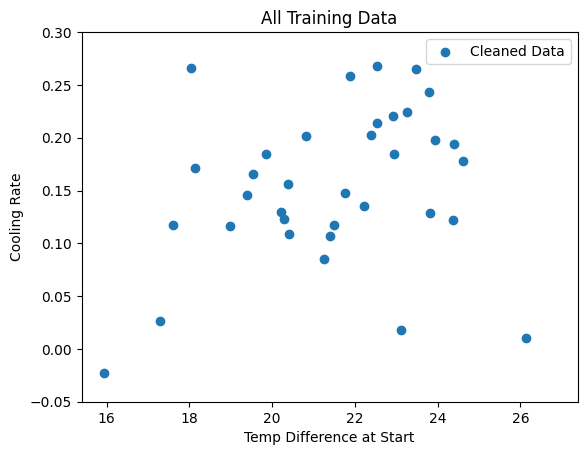

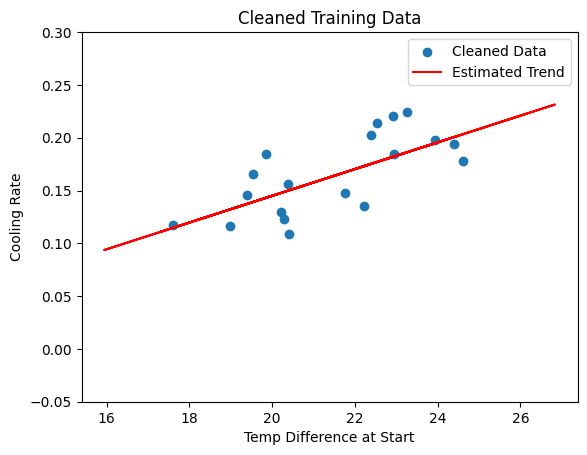

In [14]:
from sklearn.linear_model import TheilSenRegressor
from statsmodels.robust.scale import mad


plt.scatter(data_results['temp_difference_at_start'], data_results['cooling_rate'], label='Cleaned Data')
plt.xlabel('Temp Difference at Start')
plt.ylabel('Cooling Rate')
plt.ylim(-0.05, 0.30)
plt.title('All Training Data')
plt.legend()
plt.show()

# Independent and dependent variables
X = data_results[['temp_difference_at_start']].values
y = data_results['cooling_rate'].values

# Fit Theil-Sen regression (robust to outliers)
model_a = TheilSenRegressor()
model_a.fit(X, y)

# Predicted values
y_pred = model_a.predict(X)

residuals = np.abs(y - y_pred)
mad_residuals = mad(residuals)
threshold = 1.125 * mad_residuals  # Points with residuals > 3*MAD are considered outliers
outlier_mask = residuals > threshold

cleaned_df = data_results[~outlier_mask]

plt.scatter(cleaned_df['temp_difference_at_start'], cleaned_df['cooling_rate'], label='Cleaned Data')
plt.plot(data_results['temp_difference_at_start'], y_pred, color='red', label='Estimated Trend')
plt.xlabel('Temp Difference at Start')
plt.ylabel('Cooling Rate')
plt.ylim(-0.05, 0.30)
plt.title('Cleaned Training Data')
plt.legend()
plt.show()

data_results = cleaned_df

Define Linear model, fine tune it and train it

In [15]:
collerate_data = data_results[['temp_difference_at_start', 'cooling_rate']]

X = collerate_data[['temp_difference_at_start']]
y = collerate_data['cooling_rate']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(10,), (10, 10), (10, 10, 10), (25, ), (25, 25 ), (20, 20), (50,), (50, 10), (50, 50), (100, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.0001],
    'max_iter': [200, 350, 500, 750, 1000, 2000, 3000]
}

# Create and train the model
model = MLPRegressor(
    #hidden_layer_sizes=(100, 50),
    #alpha=0.0001,
    #learning_rate_init=0.0001,
    activation='relu',
    solver='adam',
    early_stopping=True,
    learning_rate='constant',
    #max_iter=500,
    random_state=42
)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("Best Estimator:", grid_search.best_estimator_)

best_model = grid_search.best_estimator_

# Evaluate on test data (assuming you have a separate test set)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 

Best Parameters: {'alpha': 0.01, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate_init': 0.001, 'max_iter': 350}
Best Score: -0.0012443575989804804
Best Estimator: MLPRegressor(alpha=0.01, early_stopping=True, hidden_layer_sizes=(10, 10, 10),
             max_iter=350, random_state=42)
Mean Squared Error: 0.0007124370451876561


Run simulation

In [18]:
# Fake data to simulate a prediction

temp_inside = 23.8
temp_outside =-2
temp_difference_actual = temp_inside - temp_outside

goal_temp = 22
goal_temperature_difference = goal_temp - temp_outside

minute = 0
predicted_cooling_rate = best_model.predict([[temp_difference_actual]])[0]

diff = temp_difference_actual - goal_temperature_difference
minutes_to_cool = diff / predicted_cooling_rate
#minutes_to_cool = round(minutes_to_cool[0])

print(f"To reach {goal_temp}°C open window for {minutes_to_cool} minutes.")

To reach 22°C open window for 7.057933824841117 minutes.


/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


Visuals

/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/agres/Projects/seb/seb_datascience/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/agres/Projects/seb/seb_datascienc

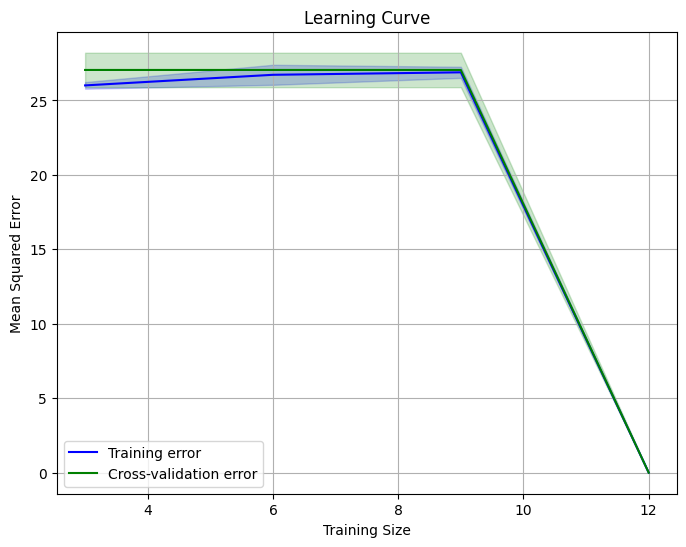

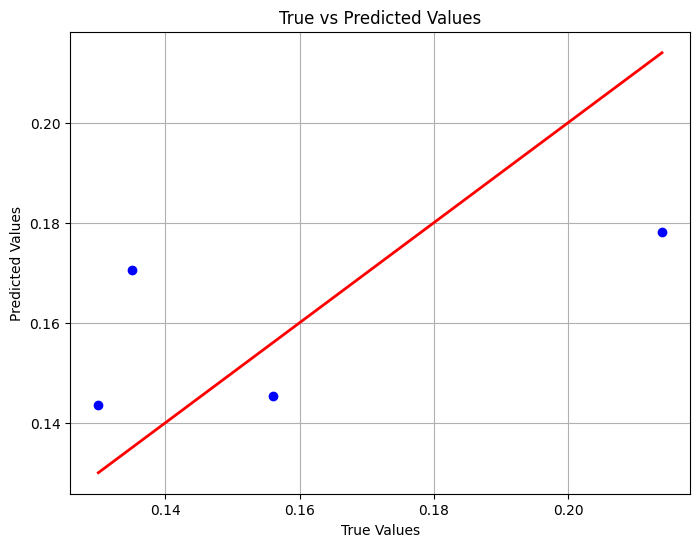

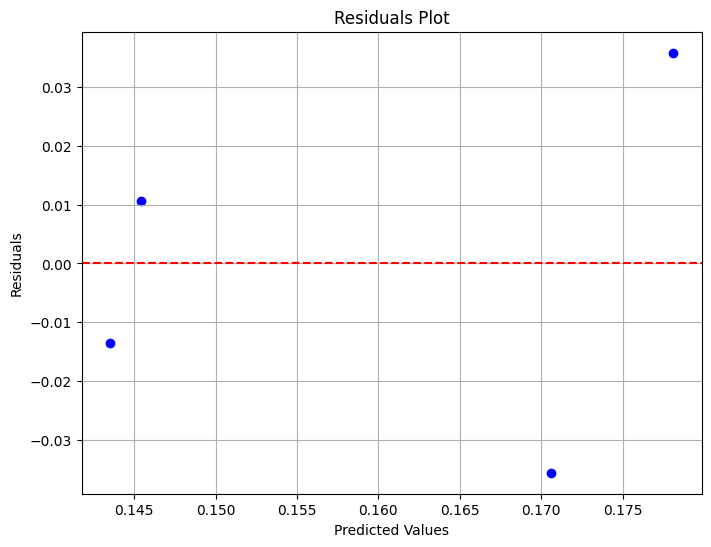

In [ ]:
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Calculate mean and std deviation for train and test scores
train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training error", color='blue')
plt.plot(train_sizes, test_mean, label="Cross-validation error", color='green')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.title("Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title("True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()